### Company XYZ is an online video streaming company, just like YouTube or Dailymotion. The Head of Product has identified as a major problem for the site a very high home page drop-off rate. That is, users come to the home-page and then leave the site without taking any action or watching any video. Since customer acquisition costs are very high, this is a huge problem: the company is spending a lot of money to acquire users who don't generate any revenue. Currently, the videos shown on the home page to new users are manually chosen. The Head of Product had this idea of creating a new recommended video section on the home page.
### He asked you the following:
#### (1) Classify each video into one the 3 categories below and explain your approach
- "Hot": means trending up. These videos are candidate to be shown.

- "Stable and Popular": video view counts are flat, but very high. These videos are candidates to be shown too.

- "Everything else": these videos won't be shown.

#### (2) What are the main characteristics of the "hot videos"? After having identified the characteristics of the hot videos, how would you use this information from a product standpoint?

### Load the package would be used

In [1]:
import pandas as pd
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 350)

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({"figure.autolayout": True})
import seaborn as sns
sns.set(style = "white")
sns.set(style = "whitegrid", color_codes = True)

import numpy as np
import statsmodels.api as sm

from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2OIsolationForestEstimator
from h2o.tree import H2OTree

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


### Read in the data set

In [2]:
count = pd.read_csv("../Datasets/online_videos/video_count.csv")
features = pd.read_csv("../Datasets/online_videos/video_features.csv")

### Look into data set

In [3]:
print(count.shape)
print(features.shape)

print(count.head)
print(features.head)

print(count.info)
print(features.info)

print(len(count["video_id"]) == len(pd.unique(count["video_id"])))
print(len(features["video_id"]) == len(pd.unique(features["video_id"])))

(41775, 3)
(2785, 5)
<bound method NDFrame.head of        video_id    count        date
0          2303       22  2015-01-07
1          1193    54854  2015-01-12
2          1219  1788779  2015-01-03
3          1472      234  2015-01-04
4          2947    14407  2015-01-08
...         ...      ...         ...
41770      2168    72747  2015-01-02
41771      2710  2986363  2015-01-08
41772       893      733  2015-01-08
41773       435   178472  2015-01-07
41774       421    23337  2015-01-10

[41775 rows x 3 columns]>
<bound method NDFrame.head of       video_id  video_length video_language video_upload_date video_quality
0         2374          1760             Cn        2014-12-06          480p
1         1897           489             Cn        2014-12-10          720p
2         2386          1273             Es        2014-12-05          480p
3         2912           986             Es        2014-12-10          240p
4         2432          1050          Other        2014-12-10       

### Data processing

In [4]:
dat = features.merge(count, on = "video_id", how = "left")
dat["video_upload_date"] = pd.to_datetime(dat["video_upload_date"])
dat["date"] = pd.to_datetime(dat["date"])
#dat = dat.sort_values(by = ["video_id", "date"])
dat.head()

,video_id,video_length,video_language,video_upload_date,video_quality,count,date
0,2374,1760,Cn,2014-12-06,480p,233510,2015-01-05
1,2374,1760,Cn,2014-12-06,480p,115542,2015-01-11
2,2374,1760,Cn,2014-12-06,480p,64475,2015-01-15
3,2374,1760,Cn,2014-12-06,480p,128935,2015-01-09
4,2374,1760,Cn,2014-12-06,480p,84993,2015-01-14


In [5]:
baseline = dat[["video_id", "date"]].groupby("video_id").min().reset_index().rename(columns = {"date": "baseline"})
baseline
dat = dat.merge(baseline, on = "video_id", how = "left").sort_values(by = ["video_id", "date"])
dat.head()

,video_id,video_length,video_language,video_upload_date,video_quality,count,date,baseline
8628,1,1496,Es,2014-12-04,720p,140460,2015-01-01,2015-01-01
8629,1,1496,Es,2014-12-04,720p,129082,2015-01-02,2015-01-01
8632,1,1496,Es,2014-12-04,720p,120868,2015-01-03,2015-01-01
8633,1,1496,Es,2014-12-04,720p,97849,2015-01-04,2015-01-01
8627,1,1496,Es,2014-12-04,720p,94821,2015-01-05,2015-01-01


In [6]:
dat["date_delta"] = (dat["date"] - dat["baseline"]).astype("timedelta64[D]")
dat["const"] = 1.0
dat.head()

,video_id,video_length,video_language,video_upload_date,video_quality,count,date,baseline,date_delta,const
8628,1,1496,Es,2014-12-04,720p,140460,2015-01-01,2015-01-01,0.0,1.0
8629,1,1496,Es,2014-12-04,720p,129082,2015-01-02,2015-01-01,1.0,1.0
8632,1,1496,Es,2014-12-04,720p,120868,2015-01-03,2015-01-01,2.0,1.0
8633,1,1496,Es,2014-12-04,720p,97849,2015-01-04,2015-01-01,3.0,1.0
8627,1,1496,Es,2014-12-04,720p,94821,2015-01-05,2015-01-01,4.0,1.0


In [7]:
def ols_res(dat, xcols, ycol):
    lin_reg = sm.OLS(dat[ycol], dat[xcols]).fit()
    intercept = lin_reg.params.values[0]
    slope = lin_reg.params.values[1]
    pvalue = lin_reg.pvalues.values[1]
    return {"intercept": intercept, "slope": slope, "pvalue": pvalue}

linear_regression_by_vedio = dat.groupby("video_id").apply(ols_res, xcols = ["const", "date_delta"], ycol = "count")
linear_regression_by_vedio.head()

video_id
1    {'intercept': 131107.25000000003, 'slope': -86...
2    {'intercept': 1816747.291666667, 'slope': -113...
3    {'intercept': 2077231.4666666668, 'slope': 307...
4    {'intercept': 2525338.8666666667, 'slope': 307...
5    {'intercept': 799541.4333333333, 'slope': -502...
dtype: object

In [8]:
reg_rows = []
for i in range(len(linear_regression_by_vedio)):
    reg_rows.append(linear_regression_by_vedio.iloc[i])

reg_dat = pd.DataFrame.from_dict(reg_rows, orient = "columns")


In [9]:
video_id = linear_regression_by_vedio.reset_index()["video_id"]
reg_dat["video_id"] = video_id

reg_dat

,intercept,slope,pvalue,video_id
0,1.311073e+05,-8638.807143,2.079332e-11,1
1,1.816747e+06,-11372.289286,9.637396e-02,2
2,2.077231e+06,30792.828571,1.185291e-02,3
3,2.525339e+06,30721.885714,2.513048e-04,4
4,7.995414e+05,-50220.585714,8.716111e-08,5
...,...,...,...,...
2780,2.419905e+05,-16372.664286,7.251005e-08,2996
2781,1.457926e+06,27817.046429,2.235300e-03,2997
2782,3.629167e+01,-0.946429,1.247745e-04,2998
2783,3.921100e+03,-278.557143,6.072334e-08,2999


#### (1) Classify each video into one the 3 categories below and explain your approach
- "Hot": means trending up. These videos are candidate to be shown.

- "Stable and Popular": video view counts are flat, but very high. These videos are candidates to be shown too.

- "Everything else": these videos won't be shown.

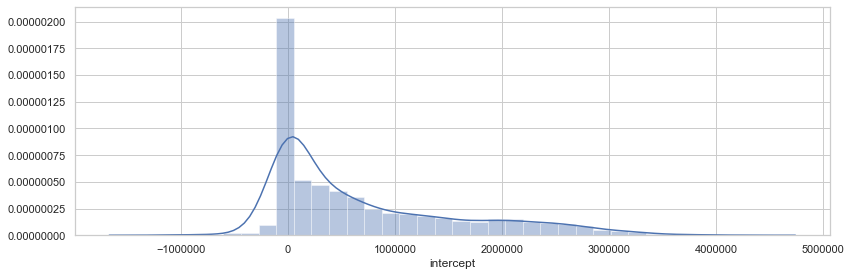

In [10]:
plt.figure(figsize = [12, 4])
sns.distplot(reg_dat["intercept"])

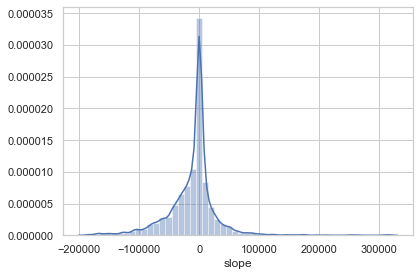

In [11]:
sns.distplot(reg_dat["slope"])

- "Hot": videos with slope greater than 0.

- "Stable and Popular": intercept greater than 1000000, and negative slope with nonsignificant p value.

- "Everything else": others.

#### (2) What are the main characteristics of the "hot videos"? After having identified the characteristics of the hot videos, how would you use this information from a product standpoint?

In [12]:
reg_dat["hot"] = reg_dat["slope"].apply(lambda x: 1 if x > 0 else 0)
reg_dat.head()

,intercept,slope,pvalue,video_id,hot
0,1.311073e+05,-8638.807143,2.079332e-11,1,0
1,1.816747e+06,-11372.289286,9.637396e-02,2,0
2,2.077231e+06,30792.828571,1.185291e-02,3,1
3,2.525339e+06,30721.885714,2.513048e-04,4,1
4,7.995414e+05,-50220.585714,8.716111e-08,5,0


In [13]:
dat = dat.merge(reg_dat[["video_id", "hot"]], on = "video_id", how = "inner")
dat_tree = dat[dat["date"] == dat["baseline"]]
dat_tree

,video_id,video_length,video_language,video_upload_date,video_quality,...,date,baseline,date_delta,const,hot
0,1,1496,Es,2014-12-04,720p,...,2015-01-01,2015-01-01,0.0,1.0,0
15,2,751,Cn,2014-12-14,480p,...,2015-01-01,2015-01-01,0.0,1.0,0
30,3,807,En,2014-12-15,1080p,...,2015-01-01,2015-01-01,0.0,1.0,1
45,4,545,En,2014-12-11,360p,...,2015-01-01,2015-01-01,0.0,1.0,1
60,5,953,En,2014-12-10,1080p,...,2015-01-01,2015-01-01,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
41700,2996,556,Es,2014-12-02,480p,...,2015-01-01,2015-01-01,0.0,1.0,0
41715,2997,300,Cn,2014-12-17,1080p,...,2015-01-01,2015-01-01,0.0,1.0,1
41730,2998,995,Other,2014-12-16,480p,...,2015-01-01,2015-01-01,0.0,1.0,0
41745,2999,1244,Es,2014-12-10,240p,...,2015-01-01,2015-01-01,0.0,1.0,0


In [14]:
#### Initialize H2O cluster
h2o.init()
h2o.remove_all()
dat_h2o = H2OFrame(dat_tree)
dat_h2o["hot"] = dat_h2o["hot"].asfactor()
dat_h2o["video_language"] = dat_h2o["video_language"].asfactor()
dat_h2o["video_quality"] = dat_h2o["video_quality"].asfactor()
dat_h2o.summary()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "12.0.1" 2019-04-16; Java(TM) SE Runtime Environment (build 12.0.1+12); Java HotSpot(TM) 64-Bit Server VM (build 12.0.1+12, mixed mode, sharing)
  Starting server from /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/kq/wd0bz4wn3hj9lylc5lbr2h140000gn/T/tmpvpx190h2
  JVM stdout: /var/folders/kq/wd0bz4wn3hj9lylc5lbr2h140000gn/T/tmpvpx190h2/h2o_veronica_started_from_python.out
  JVM stderr: /var/folders/kq/wd0bz4wn3hj9lylc5lbr2h140000gn/T/tmpvpx190h2/h2o_veronica_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.1
H2O cluster version age:,23 days
H2O cluster name:,H2O_from_python_veronica_jc8yrl
H2O cluster total nodes:,1
H2O cluster free memory:,4 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


,video_id,video_length,video_language,video_upload_date,video_quality,count,date,baseline,date_delta,const,hot
type,int,int,enum,time,enum,int,time,time,int,int,enum
mins,1.0,9.0,,1417478400000.0,,6.0,1420070400000.0,1420070400000.0,0.0,1.0,
mean,1498.6732495511662,684.813285457811,,1418352296445.2412,,749853.1371633774,1420070400000.0,1420070400000.0,0.0,1.0,
maxs,3000.0,2114.0,,1419379200000.0,,3982099.0,1420070400000.0,1420070400000.0,0.0,1.0,
sigma,864.2396874160493,422.4916856746862,,482653196.3539807,,893348.514859978,0.0,0.0,0.0,0.0,
zeros,0,0,,0,,0,0,0,2785,0,
missing,0,0,0,0,0,0,0,0,0,0,0
0,1.0,1496.0,Es,2014-12-04 00:00:00,720p,140460.0,2015-01-01 00:00:00,2015-01-01 00:00:00,0.0,1.0,0
1,2.0,751.0,Cn,2014-12-14 00:00:00,480p,2011096.0,2015-01-01 00:00:00,2015-01-01 00:00:00,0.0,1.0,0
2,3.0,807.0,En,2014-12-15 00:00:00,1080p,2386683.0,2015-01-01 00:00:00,2015-01-01 00:00:00,0.0,1.0,1


In [15]:
index = dat_h2o["hot"].stratified_split(test_frac = 0.34, seed = 2019)
train_dat = dat_h2o[index == "train"]
test_dat = dat_h2o[index == "test"]
X = ["video_length", "video_language", "video_upload_date", "video_quality"]
Y = "hot"

In [16]:
tree_model = H2OIsolationForestEstimator(sample_rate = 0.1, max_depth = 20, ntrees = 50)
tree_model.train(x = X, y = Y, training_frame = train_dat)

isolationforest Model Build progress: |███████████████████████████████████| 100%


In [17]:
GBM = H2OGradientBoostingEstimator(balance_classes = True, ntrees = 1, min_rows = 1, sample_rate = 1,  
                                   col_sample_rate = 1, max_depth = 5, seed = 2019)
GBM.train(x = X, y = Y, training_frame = train_dat)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [18]:
tree = H2OTree(model = GBM, tree_number = 0, tree_class = None)
print(tree.root_node)
print(tree.root_node.left_child)
print(tree.root_node.right_child)
print(tree.root_node.left_child.left_child)
print(tree.root_node.left_child.right_child)
print(tree.root_node.right_child.left_child)
print(tree.root_node.right_child.right_child)

print(tree.root_node.left_child.right_child.left_child)
print(tree.root_node.left_child.right_child.right_child)

print(tree.root_node.right_child.left_child.left_child)
print(tree.root_node.right_child.left_child.right_child)

print(tree.root_node.left_child.right_child.right_child.left_child)
print(tree.root_node.left_child.right_child.right_child.right_child)

Node ID 0 
Left child node ID = 1
Right child node ID = 2

Splits on column video_upload_date
Split threshold < 1418298920000.0 to the left node, >= 1418298920000.0 to the right node 

NA values go to the RIGHT
Node ID 1 
Left child node ID = 33
Right child node ID = 4

Splits on column video_upload_date
Split threshold < 1418040050000.0 to the left node, >= 1418040050000.0 to the right node 

Node ID 2 
Left child node ID = 5
Right child node ID = 34

Splits on column video_upload_date
Split threshold < 1418904470000.0 to the left node, >= 1418904470000.0 to the right node 

NA values go to the LEFT
Leaf node ID 33. Predicted value at leaf node is -0.20254385 

Node ID 4 
Left child node ID = 7
Right child node ID = 8

Splits on column video_length
Split threshold < 948.5 to the left node, >= 948.5 to the right node 

NA values go to the LEFT
Node ID 5 
Left child node ID = 9
Right child node ID = 10

Splits on column video_upload_date
Split threshold < 1418558700000.0 to the left nod